In [ ]:
#!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes datasets

In [1]:
import torch
import random
import numpy as np
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name()}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Using device: cuda
CUDA available: True
GPU: Tesla P100-PCIE-16GB
GPU Memory: 15.9 GB


This object has a hole in it.
<PIL.PngImagePlugin.PngImageFile image mode=RGB size=224x224 at 0x7A9887C18F10>


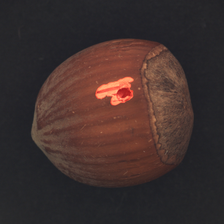

In [2]:
from datasets import Dataset, Image
import json
from PIL import Image as PILImage


def load_custom_dataset(jsonl_path, base_dir):
    """
    Custom function to load the dataset with full control
    """
    data = [] 
    with open(jsonl_path, 'r') as f:
        for line in f:
            item = json.loads(line.strip())
            # Make sure image paths are absolute
            item['image'] = os.path.join(base_dir, item['image'])
            data.append(item)
    
    dataset = Dataset.from_list(data)
    dataset = dataset.cast_column('image', Image())
    
    return dataset

#dataset_path = '/kaggle/input/vlm-ad-dataset-word'
dataset_path = '/kaggle/input/vlm-dataset-fullcaption'
jsonl_path = os.path.join(dataset_path, 'dataset.jsonl')

dataset = load_custom_dataset(jsonl_path, dataset_path)

# Access data
print(dataset[0]['text'])   
print(dataset[0]['image'])
dataset[0]['image']  

In [3]:
from torch.utils.data import Dataset, DataLoader

PROMPT = "Question: What kind of anomaly is on this object? Answer:"

class ImageDataset(Dataset):
    def __init__(self, dataset, processor, prompt = PROMPT):
        self.dataset = dataset
        self.processor = processor
        self.prompt = prompt

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]
        
        encoding = self.processor(images=item["image"], padding="max_length", return_tensors="pt")
        encoding = {k: v.squeeze() for k, v in encoding.items()}
        
        encoding["text"] = self.prompt + item["text"]
        
        return encoding

def collate_fn(batch):
    
    processed_batch = {}
    for key in batch[0].keys():
        if key != "text":
            processed_batch[key] = torch.stack([example[key] for example in batch])
        else:
            text_inputs = processor.tokenizer(
                [example["text"] for example in batch], padding=True, return_tensors="pt"
            )
            processed_batch["input_ids"] = text_inputs["input_ids"]
            processed_batch["attention_mask"] = text_inputs["attention_mask"]
    return processed_batch
    

In [4]:
from transformers import AutoProcessor, Blip2ForConditionalGeneration, BitsAndBytesConfig
from peft import LoraConfig, get_peft_model

processor = AutoProcessor.from_pretrained(
                "Salesforce/blip2-opt-2.7b",
                use_fast=True)

model = Blip2ForConditionalGeneration.from_pretrained(
                "Salesforce/blip2-opt-2.7b", 
                device_map = "auto", 
                torch_dtype = torch.float16)

lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    lora_dropout=0.05,
    bias="none",
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "fc1", "fc2"]
)

model = get_peft_model(model, lora_config)
model.print_trainable_parameters()

2025-08-30 11:06:17.981553: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1756551978.178285      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1756551978.234444      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

trainable params: 30,396,416 || all params: 3,775,158,272 || trainable%: 0.8052


In [5]:
dataset_split = dataset.train_test_split(test_size=0.2, seed=42)

train_split_dataset = dataset_split["train"]
test_split_dataset  = dataset_split["test"]

train_dataset = ImageDataset(train_split_dataset, processor)
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=4, collate_fn=collate_fn)

test_dataset = ImageDataset(test_split_dataset, processor)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=1, collate_fn=collate_fn)

In [6]:
import torch
from tqdm import tqdm 
from transformers import get_scheduler

NUM_EPOCHS = 5
LEARNING_RATE = 1e-4


optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.01)

num_training_steps = NUM_EPOCHS * len(train_dataloader)
warmup_steps = 0.03 * num_training_steps
lr_scheduler = get_scheduler(
    name="linear",
    optimizer=optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=num_training_steps,
)

device = "cuda" if torch.cuda.is_available() else "cpu"

training_losses = []

model.train()
for epoch in range(NUM_EPOCHS):
    #print(f"Epoch: {epoch + 1}/{NUM_EPOCHS}")

    progress_bar = tqdm(train_dataloader, desc=f'Training Epoch {epoch+1}/{NUM_EPOCHS}')
    
    epoch_losses = []
    for idx, batch in enumerate(progress_bar):

        input_ids = batch.pop("input_ids").to(device)
        pixel_values = batch.pop("pixel_values").to(device, torch.float16)
    
        outputs = model(input_ids=input_ids,
                        pixel_values=pixel_values,
                        labels=input_ids)
        
        loss = outputs.loss
        epoch_losses.append(loss.item())
    
        loss.backward()
   
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        progress_bar.set_postfix({'loss': f'{loss.item():.4f}'})

        
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    training_losses.append(avg_epoch_loss)
    print(f'Epoch {epoch + 1} Average Loss: {avg_epoch_loss:.4f}')

print("Training completed!")
print(f"Final average loss: {training_losses[-1]:.4f}")

Training Epoch 1/5: 100%|██████████| 243/243 [04:29<00:00,  1.11s/it, loss=0.0424]


Epoch 1 Average Loss: 0.4555


Training Epoch 2/5: 100%|██████████| 243/243 [04:21<00:00,  1.07s/it, loss=0.0848]


Epoch 2 Average Loss: 0.0629


Training Epoch 3/5: 100%|██████████| 243/243 [04:20<00:00,  1.07s/it, loss=0.0586]


Epoch 3 Average Loss: 0.0612


Training Epoch 4/5: 100%|██████████| 243/243 [04:19<00:00,  1.07s/it, loss=0.0539]


Epoch 4 Average Loss: 0.0605


Training Epoch 5/5: 100%|██████████| 243/243 [04:18<00:00,  1.07s/it, loss=0.0583]

Epoch 5 Average Loss: 0.0586
Training completed!
Final average loss: 0.0586


## Inference

This object has a scratch on it.


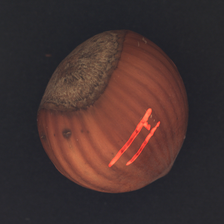

In [7]:
index = 10

example_text = test_split_dataset[index]['text']
example_image = test_split_dataset[index]['image']

print(example_text)   
example_image

In [ ]:
inputs = processor(images=example_image, text=PROMPT, return_tensors="pt").to(device, torch.float16)
pixel_values = inputs.pixel_values

generated_ids = model.generate(
    pixel_values=pixel_values, 
    max_length=40,
    #temperature=0.6,  
    #top_p=0.9,
    #do_sample=True
    )
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print(f"{PROMPT}\n{generated_caption}")
example_image

## Saving model on HuggingFace

```python
from huggingface_hub import notebook_login
notebook_login()
```
---
```python
model.push_to_hub("tonipol/blip2-opt-2.7b-anomaly-detection-description")
```

In [8]:
#from huggingface_hub import notebook_login
#notebook_login()

In [9]:
#model.push_to_hub("tonipol/blip2-opt-2.7b-anomaly-detection-description")

Uploading...:   0%|          | 0.00/122M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/tonipol/blip2-opt-2.7b-anomaly-detection-description/commit/a00cd0259421b341b72fa8d9231d1ae411113e2b', commit_message='Upload model', commit_description='', oid='a00cd0259421b341b72fa8d9231d1ae411113e2b', pr_url=None, repo_url=RepoUrl('https://huggingface.co/tonipol/blip2-opt-2.7b-anomaly-detection-description', endpoint='https://huggingface.co', repo_type='model', repo_id='tonipol/blip2-opt-2.7b-anomaly-detection-description'), pr_revision=None, pr_num=None)

### How to load from HuggingFace

```python
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "tonipol/blip2-opt-2.7b-anomaly-detection-description"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
```

In [ ]:
'''
from transformers import Blip2ForConditionalGeneration, AutoProcessor
from peft import PeftModel, PeftConfig

peft_model_id = "tonipol/blip2-opt-2.7b-anomaly-detection-description"
config = PeftConfig.from_pretrained(peft_model_id)

model = Blip2ForConditionalGeneration.from_pretrained(config.base_model_name_or_path, device_map="auto")
model = PeftModel.from_pretrained(model, peft_model_id)

processor = AutoProcessor.from_pretrained("Salesforce/blip2-opt-2.7b")
'''

In [11]:
from tqdm import tqdm

PROMPT = "Question: What kind of anomaly is on this object? Answer:"
defects = ['crack', 'hole', 'writing', 'scratch']
matrix = {
    'crack':   {'true': 0, 'false': 0},
    'hole':    {'true': 0, 'false': 0},
    'scratch': {'true': 0, 'false': 0},
    'writing': {'true': 0, 'false': 0},
    'other': 0
}

matrix2 = {
    'crack':   {'crack': 0, 'hole': 0, 'scratch': 0, 'writing': 0},
    'hole':    {'crack': 0, 'hole': 0, 'scratch': 0, 'writing': 0},
    'scratch': {'crack': 0, 'hole': 0, 'scratch': 0, 'writing': 0},
    'writing': {'crack': 0, 'hole': 0, 'scratch': 0, 'writing': 0},
}

true_captions = []
generated_captions = []


for index in tqdm(range(len(test_split_dataset)), desc='Testing model'):
#for index in range(len(test_split_dataset)):
 
    img = test_split_dataset[index]['image']
    true_caption = test_split_dataset[index]['text']

    true_defect = next((d for d in defects if d in true_caption), None)
    if true_defect is None:
        continue
        
    inputs = processor(images=img, text=PROMPT, return_tensors="pt").to(device, torch.float16)
    pixel_values = inputs.pixel_values
    
    generated_ids = model.generate(
        pixel_values=pixel_values, 
        max_length=50,
        temperature=0.7,  
        top_p=0.9,
        do_sample=True
        )
    generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    pred_defect = next((d for d in defects if d in generated_caption), None)
    if pred_defect is None:
        matrix['other'] += 1
        continue

    if pred_defect == true_defect:
        matrix[pred_defect]['true'] += 1
    else:
        matrix[pred_defect]['false'] += 1

    matrix2[true_defect][pred_defect] += 1
    
    true_captions.append(true_caption)
    generated_captions.append(generated_caption)


print(matrix)
print('')
print(matrix2)

Testing model: 100%|██████████| 244/244 [03:28<00:00,  1.17it/s]

{'crack': {'true': 44, 'false': 93}, 'hole': {'true': 15, 'false': 42}, 'scratch': {'true': 23, 'false': 27}, 'writing': {'true': 0, 'false': 0}, 'other': 0}

{'crack': {'crack': 44, 'hole': 21, 'scratch': 17, 'writing': 0}, 'hole': {'crack': 30, 'hole': 15, 'scratch': 7, 'writing': 0}, 'scratch': {'crack': 55, 'hole': 18, 'scratch': 23, 'writing': 0}, 'writing': {'crack': 8, 'hole': 3, 'scratch': 3, 'writing': 0}}


In [14]:
for true, gen in zip(true_captions, generated_captions):
    print(f'True: {true}\nGen:  {gen}')

True: This object has a crack along its edge.
Gen:  this object has a crack along its edge

True: This object has a scratch on it.
Gen:  this object has a hole in it, and it has a crack along its edge

True: This object has a crack along its edge.
Gen:  this object has a hole in it

True: This object has a crack along its edge.
Gen:  this object has a crack along its edge

True: This object has a scratch on it.
Gen:  this object has a crack along its edge

True: This object has a scratch on it.
Gen:  This object has a scratch on it. 4090
True: This object has a scratch on it.
Gen:  this object has a crack along its edge

True: This object has a hole in it.
Gen:  this object has a crack along its edge

True: This object has a scratch on it.
Gen:  this object has a hole in it. object has a hole in it
True: This object has a scratch on it.
Gen:  This object has a scratch on it. object has a scratch on it.
True: This object has a scratch on it.
Gen:  this object has a crack along its edge


In [11]:
cracks, holes, scratches, writings = 0, 0, 0, 0
test_set = {
    'crack': 0,
    'hole': 0,
    'scratch': 0,
    'writing': 0
}

for index in range(len(test_split_dataset)):
    true_caption = test_split_dataset[index]['text']
    true_defect = next((d for d in defects if d in true_caption), None)
    test_set[true_defect] += 1

print(test_set)

{'crack': 82, 'hole': 52, 'scratch': 96, 'writing': 14}
